#Bayesian Forecasting and Dynamic Models
url:https://github.com/lavinei/pybats_nbdev/blob/master/examples/Poisson_DGLM_In_Depth_Example.ipynb

Package: pybats

published: may 2020

github:https://github.com/lavinei/pybats_nbdev


In [1]:
!pip install pybats

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar
from pybats import analysis
from pybats.point_forecast import median
from pybats.plot import plot_data_forecast, ax_style, plot_coef
from pybats.shared import load_sales_example2

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import files
uploaded = files.upload() 

Saving tourism.csv to tourism (2).csv


In [4]:
import io
# load the data 
df = pd.read_csv(io.BytesIO(uploaded['tourism.csv'])) \
       .drop(columns=["Unnamed: 0"])

In [5]:
# lowercase the column names
df.columns = [col_name.lower() for col_name in df.columns]

# sum the trips over purpose
df = df.groupby(["quarter", "region", "state"])["trips"] \
       .sum() \
       .reset_index(drop=False)

# cleanup region name 
df["region"] = df["region"].apply(lambda x: x.replace(" ", "_").replace("'", ""))

# map the full state names to abbreviations
mapping_dict = {
    "New South Wales": "NSW",
    "Northern Territory": "NT",
    "Queensland": "QLD",
    "South Australia": "SA",
    "Victoria": "VIC",
    "Western Australia": "WA",
    "ACT": "ACT",
}

df["state"] = df["state"].map(mapping_dict)

# create the bottom level id
df["state_region"] = df.apply(lambda x: f"{x['state']}_{x['region']}", axis=1)

df.head()

,quarter,region,state,trips,state_region
0,1998-01-01,Adelaide,SA,658.553895,SA_Adelaide
1,1998-01-01,Adelaide_Hills,SA,9.798630,SA_Adelaide_Hills
2,1998-01-01,Alice_Springs,NT,20.207638,NT_Alice_Springs
3,1998-01-01,Australias_Coral_Coast,WA,132.516409,WA_Australias_Coral_Coast
4,1998-01-01,Australias_Golden_Outback,WA,161.726948,WA_Australias_Golden_Outback


In [6]:
df.groupby("state")["region"].apply(set).to_frame()

,region
state,
ACT,{Canberra}
NSW,"{Central_NSW, Outback_NSW, New_England_North_W..."
NT,"{East_Coast, North_West, MacDonnell, Launcesto..."
QLD,"{Sunshine_Coast, Tropical_North_Queensland, Go..."
SA,"{Eyre_Peninsula, Yorke_Peninsula, Flinders_Ran..."
VIC,"{Spa_Country, Peninsula, Gippsland, Lakes, Bal..."
WA,"{Australias_North_West, Experience_Perth, Aust..."


In [7]:
# create the bottom level df
df_bottom_level = df.pivot(index="quarter", columns="state_region", values="trips")

# create the middle level df
df_middle_level = df.groupby(["quarter", "state"]) \
                    .sum() \
                    .reset_index(drop=False) \
                    .pivot(index="quarter", columns="state", values="trips")

# create the total level df
df_total = df.groupby("quarter")["trips"] \
             .sum() \
             .to_frame() \
             .rename(columns={"trips": "total"})

# join the DataFrames
hierarchy_df = df_bottom_level.join(df_middle_level) \
                              .join(df_total)
hierarchy_df.index = pd.to_datetime(hierarchy_df.index)
hierarchy_df = hierarchy_df.resample("QS") \
                           .sum()

print(f"Number of time series at the bottom level: {df_bottom_level.shape[1]}")
print(f"Number of time series at the middle level: {df_middle_level.shape[1]}")
print(hierarchy_df.shape)
print(hierarchy_df.head())
print(hierarchy_df.tail())



Number of time series at the bottom level: 77
Number of time series at the middle level: 7
(76, 85)
            ACT_Canberra  NSW_Blue_Mountains  ...           WA         total
quarter                                       ...                           
1998-01-01    551.001921          195.543180  ...  1641.089495  23932.544141
1998-04-01    416.025623          200.408671  ...  1576.326534  20856.726540
1998-07-01    436.029011          253.359689  ...  1588.293692  20222.802189
1998-10-01    449.798445          245.573846  ...  1839.716990  21342.960517
1999-01-01    378.572817          290.484124  ...  1835.687573  22801.711403

[5 rows x 85 columns]
            ACT_Canberra  NSW_Blue_Mountains  ...           WA         total
quarter                                       ...                           
2015-10-01    542.769655          203.906222  ...  2382.091755  25759.429177
2016-01-01    626.640631          239.080991  ...  2797.404767  27492.360374
2016-04-01    592.608499      

In [8]:
prior_length = 6   # Number of days of data used to set prior
k = 1               # Forecast horizon
# rho = 0.5           # Random effect discount factor to increase variance of forecast distribution
# #forecast_samps = 5  # Number of forecast samples to draw
forecast_start = pd.to_datetime('1999-10-01') # Date to start forecasting
forecast_end = pd.to_datetime('2016-10-01')   # Date to stop forecasting
forecast_endk=pd.to_datetime('2017-01-01')

mod, samples, = analysis.analysis(hierarchy_df.total.values, hierarchy_df[['SA_Adelaide_Hills', 'SA']].values,
                        k, forecast_start, forecast_end, 
                        family='normal',
                        dates=hierarchy_df.index, 
                        prior_length=6,                     # How many data point to use in defining prior
                        rho=.5,                             # Random effect extension, which increases the forecast variance (see Berry and West, 2019)
                       deltrend=0.95,                      # Discount factor on the trend component (the intercept)
                      delregn=0.95  )

beginning forecasting


RMSE 21675.80984097508


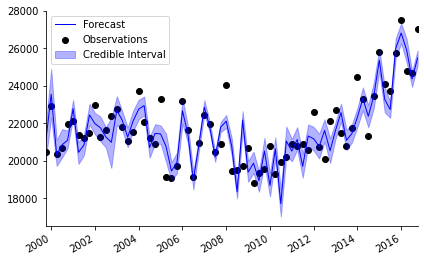

In [9]:
data_1step = hierarchy_df.loc[forecast_start:forecast_end]
samples_1step = samples[:,:,0]
fig, ax = plt.subplots(1,1)
ax = plot_data_forecast(fig, ax,
                        data_1step.total,
                        median(samples_1step),
                        samples_1step,
                        data_1step.index,
                        credible_interval=75)


from statsmodels.tools.eval_measures import rmse

print('RMSE',rmse(data_1step.SA_Adelaide_Hills,median(samples_1step)))

In [10]:
k = 1               # Forecast horizon
# rho = 0.5           # Random effect discount factor to increase variance of forecast distribution
# #forecast_samps = 5  # Number of forecast samples to draw
forecast_start = pd.to_datetime('1999-10-01') # Date to start forecasting
forecast_end = pd.to_datetime('2016-10-01')   # Date to stop forecasting
forecast_endk=pd.to_datetime('2017-01-01')

mod, samples, = analysis.analysis(hierarchy_df.SA.values, hierarchy_df[['SA_Adelaide_Hills', 'total']].values,
                        k, forecast_start, forecast_end, 
                        family='normal',
                        dates=hierarchy_df.index, 
                        prior_length=6,                     # How many data point to use in defining prior
                        rho=.5,                             # Random effect extension, which increases the forecast variance (see Berry and West, 2019)
                       deltrend=0.95,                      # Discount factor on the trend component (the intercept)
                      delregn=0.95  )

beginning forecasting


RMSE 1445.9002736213686


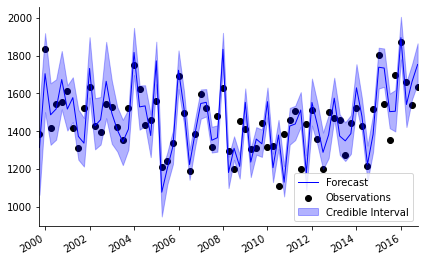

In [11]:
data_1step = hierarchy_df.loc[forecast_start:forecast_end]
samples_1step = samples[:,:,0]
fig, ax = plt.subplots(1,1)
ax = plot_data_forecast(fig, ax,
                        data_1step.SA,
                        median(samples_1step),
                        samples_1step,
                        data_1step.index,
                        credible_interval=75)

from statsmodels.tools.eval_measures import rmse

print('RMSE',rmse(data_1step.SA_Adelaide_Hills,median(samples_1step)))

In [12]:
prior_length = 6   # Number of days of data used to set prior
k = 1               # Forecast horizon
# rho = 0.5           # Random effect discount factor to increase variance of forecast distribution
# #forecast_samps = 5  # Number of forecast samples to draw
forecast_start = pd.to_datetime('1999-10-01') # Date to start forecasting
forecast_end = pd.to_datetime('2016-10-01')   # Date to stop forecasting
forecast_endk=pd.to_datetime('2017-01-01')

mod, samples, = analysis.analysis(hierarchy_df.SA_Adelaide_Hills.values, hierarchy_df[['SA', 'total']].values,
                        k, forecast_start, forecast_end, 
                        family='normal',
                        dates=hierarchy_df.index, 
                        prior_length=6,                     # How many data point to use in defining prior
                        rho=.5,                             # Random effect extension, which increases the forecast variance (see Berry and West, 2019)
                       deltrend=0.95,                      # Discount factor on the trend component (the intercept)
                      delregn=0.95  )



beginning forecasting


RMSE 19.11746790977628


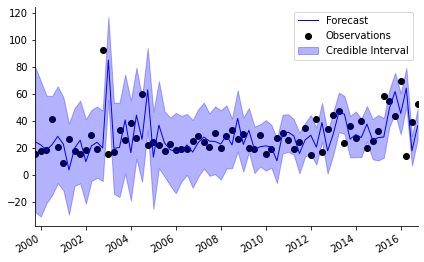

In [13]:
data_1step = hierarchy_df.loc[forecast_start:forecast_end]
samples_1step = samples[:,:,0]
fig, ax = plt.subplots(1,1)
ax = plot_data_forecast(fig, ax,
                        data_1step.SA_Adelaide_Hills,
                        median(samples_1step),
                        samples_1step,
                        data_1step.index,
                        credible_interval=75)

from statsmodels.tools.eval_measures import rmse

print('RMSE',rmse(data_1step.SA_Adelaide_Hills,median(samples_1step)))